# ATMS 523 Final Project
### Author: Domenic Brooks

# Objective
The purpose of this project is to investigate the relationship between teleconnection patterns and monthly winter snowfall totals for a given city. The goal of this project is to produce a tool to run an ML model to predict the amount of snowfall based on the given teleconnections, and understand which teleconnections have the largest impact on the predictability. 

# Data
For snowfall, the dataset used is ERA-5 reanalysis. While perhaps not the most accurate or precise for snowfall records, it does provide a continous gridded dataset for a period of record dating back to 1940, which is essential for gathering enough seasons for the ML model training. (see readme for documentation)

For teleconnections, the NOAA Climate Prediction Center (CPC) and NCEI provide tabular datasets for monthly indices dating back to 1950 for various teleconnections, the ones which will be used in this project are:

- El Nino Southern Oscillation (ENSO)
- North Atlantic Oscillation (NAO)
- Arctic Osciallation (AO)
- Pacific North American Oscillation (PNA)
- Pacific Decadal Oscillation (PDO)
- Indian Ocean Dipole (IOD)

# Methodology

My approach first involved summing up the snowfall for Baltimore, MD by month, and then computing standardized anomalies based on the 1981-2010 base period for monthly snowfall which would be used in the analysis. I then created a 1-month lagged correlation, so that I could calculate the correlation between snowfall anoms for a given month and the teleconnections for the month prior. From there, I garnered which month seemingly had the most predictability based on this method, and conducted a series of test and analysis to find the best regression model that could predict snowfall anomalies for the given month. 

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import scipy.stats as stats
import cartopy.feature as cfeature
import cartopy.crs as ccrs 

# Teleconnection Dataset Processing

In [3]:
# ENSO
enso = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.el_nino.dat',
                   sep=r'\s+', header=None, skiprows=0, engine='python')
# Grab ENSO 3.4 values and reformat for proper merging later                   
enso = enso[[0,1,4]].pivot_table(values=4, index=0, columns=1).reset_index()

# NAO
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')

# AO
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')

# PNA
pna = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.pna.monthly.b5001.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')  

# PDO
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',
                  sep=r'\s+', header=None, skiprows=2, engine='python')

# IOD
iod = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.iod.dat',
                  sep=r'\s+', header=None, skiprows=1, engine='python')
# Grab difference values and reformat for proper merging later              
iod = iod[[0,1,4]].pivot_table(values=4, index=0, columns=1).reset_index()

In [4]:
###### Create merged dataframe for all indices #######

enso_new=pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()
pna_new=pd.DataFrame()
iod_new=pd.DataFrame()

# Create monthly date intervals
enso_new['Date'] = pd.date_range(start=datetime.datetime(enso[0].iloc[0],1,1),end=datetime.datetime(enso[0].iloc[-1],12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")
pna_new['Date'] = pd.date_range(start=datetime.datetime(pna[0].iloc[0],1,1),end=datetime.datetime(pna[0].iloc[-1],12,1),freq="MS")
iod_new['Date'] = pd.date_range(start=datetime.datetime(iod[0].iloc[0],1,1),end=datetime.datetime(iod[0].iloc[-1],12,1),freq="MS")

# Set the monthly timesteps to the index
enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')
pna_new = pna_new.set_index('Date')
iod_new = iod_new.set_index('Date')

# Add teleconnection indices to date index
enso_new['ENSO']=enso.loc[:,1:].stack(dropna=False).values
nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values
pna_new['PNA']=pna.loc[:,1:].stack(dropna=False).values
iod_new['IOD']=iod.loc[:,1:].stack(dropna=False).values

# Merge all dataframes and also account for missnig value markers
newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PDO'] >= 99.,'PDO'] = np.nan
newdf_all.loc[newdf_all['ENSO'] <= -99.9,'ENSO'] = np.nan
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['NAO'] <= -99.9,'NAO'] = np.nan
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['AO'] <= -99.9,'AO'] = np.nan
newdf_all = pd.merge(newdf_all,pna_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PNA'] <= -99.9,'PNA'] = np.nan
newdf_all = pd.merge(newdf_all,iod_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['IOD'] <= -99.9,'IOD'] = np.nan

# Resample to seasonal means
#newdf_all = newdf_all.resample('QS-DEC', closed='left', label='left').mean()

newdf_all

C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_18132\2434704326.py:27: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  enso_new['ENSO']=enso.loc[:,1:].stack(dropna=False).values
C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_18132\2434704326.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_18132\2434704326.py:29: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes

,ENSO,PDO,NAO,AO,PNA,IOD
Date,,,,,,
1950-01-01,-2.04,-1.61,0.92,-0.060,-2.34,-0.01
1950-02-01,-1.72,-2.17,0.40,0.627,-1.04,-0.51
1950-03-01,-1.38,-1.89,-0.36,-0.008,0.24,-0.29
1950-04-01,-1.41,-1.99,0.73,0.555,0.01,-0.12
1950-05-01,-1.62,-3.19,-0.59,0.072,-0.55,-0.09
...,...,...,...,...,...,...
2025-08-01,-0.32,-3.19,0.26,0.036,-0.36,-0.45
2025-09-01,-0.50,-2.31,-0.80,0.048,0.81,-0.57
2025-10-01,-0.48,-2.36,-0.96,0.064,1.42,-0.83


# ERA-5 data retrieval

In [4]:
# Start dask client
from dask.distributed import Client
client = Client() 
client

/global/homes/d/dbrooks/.conda/envs/atms-shap/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35053 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35053/status,
Dashboard: http://127.0.0.1:35053/status,Workers: 16
Total threads: 256,Total memory: 502.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43351,Workers: 0
Dashboard: http://127.0.0.1:35053/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46323,Total threads: 16
Dashboard: http://127.0.0.1:45989/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:45055,


In [5]:
# Load full ERA-5 datast
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={"time": 30},
    storage_options=dict(token='anon'),
)
ds

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * time                                                             (time) datetime64[ns] 11MB ...
  * latitude                                                         (latitude) float32 3kB ...
  * longitude                                                        (longitude) float32 6kB ...
  * level                                                            (level) int64 296B ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-12-08 02:08:54.302123+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-08-31
    valid_time_stop_era5t:  2025-12-02

In [ ]:
# Function for selecting city data
def get_era5_data_for_city(ds, var, city_lon, city_lat, start_time, end_time):
    """
    This function serves to grab ERA-5 data for a given variable
    for a given city for a given timeframe.

    Inputs:
    - ds (xarray.Dataset): ERA-5 dataset with all the variables.
    - var (str): Variable you want to grab from the data.
    - city_lon (float): Longitude of selected city.
    - city_lat (float): Latitude of selected city.
    - start time (str): Desired start time (yyyy-mm-dd HH:MM)
    - end time (str): Desired end time (yyyy-mm-dd HH:MM)

    Returns:
    - ds2 (xarray.DataArray): A DataArray containing the data for grid point.
    """

    ds2 = ds[var].sel(
        latitude=city_lat,
        longitude=city_lon+360,
        method='nearest'
    )

    ds2 = ds2.sel(time=slice(start_time, end_time))

    return ds2

var = 'snowfall'
city_lon, city_lat = -76.609484,39.289221 # Baltimore, MD
start_time, end_time = '1950-09-01 01:00','2025-02-28 23:00'

# Run function
city_ds = get_era5_data_for_city(
    ds, var, city_lon, city_lat, start_time, end_time)

In [7]:
# Loading into memory takes ~4 min
city_ds = city_ds.compute()
city_ds = city_ds * 1000 # m to mm
print(city_ds)

<xarray.DataArray 'snowfall' (time: 653039)> Size: 3MB
array([ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -4.656613e-07,
       -4.656613e-07, -4.656613e-07], shape=(653039,), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 5MB 1950-09-01T01:00:00 ... 2025-02-28T2...
    latitude   float32 4B 37.75
    longitude  float32 4B 240.2
Attributes:
    long_name:      Snowfall
    short_name:     sf
    standard_name:  lwe_thickness_of_snowfall_amount
    units:          m of water equivalent


In [5]:
#city_ds.to_netcdf('Baltimore_snowfall.nc', engine='h5netcdf')
city_ds = xr.open_dataarray('Baltimore_snowfall.nc', engine='h5netcdf')

In [13]:
city_ds

<xarray.DataArray 'snowfall' (time: 653039)> Size: 3MB
[653039 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 5MB 1950-09-01T01:00:00 ... 2025-02-28T2...
    latitude   float32 4B ...
    longitude  float32 4B ...
Attributes:
    long_name:      Snowfall
    short_name:     sf
    standard_name:  lwe_thickness_of_snowfall_amount
    units:          m of water equivalent

# Process snowfall data

In [17]:
# Turn array into dataframe, and resample to monthly totals
snow_ds = city_ds.to_dataframe().drop(['latitude','longitude'], axis=1)
snow_ds = snow_ds.resample('MS', closed='left', label='left').sum()
snow_ds.index.name = 'Date'

# Keep only monthly totals from primary snow season months
# (Nov, Dec, Jan, Feb, and March)
snow_ds = snow_ds[snow_ds.index.month.isin([11,12,1,2,3])].copy()
snow_ds

,snowfall
Date,
1950-11-01,2.396713
1950-12-01,12.560315
1951-01-01,8.188605
1951-02-01,6.260388
1951-03-01,0.287124
...,...
2024-03-01,0.004233
2024-11-01,0.553151
2024-12-01,0.624573


C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_18132\1811394420.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(snow_ds.rolling(window=15, center=False).mean(), label='15-Month Rolling Mean', c='red', linewidth=3)


Text(0.5, 1.0, 'Monthly Snowfall Totals (Nov-Mar) for Baltimore, MD (1950-2025)')

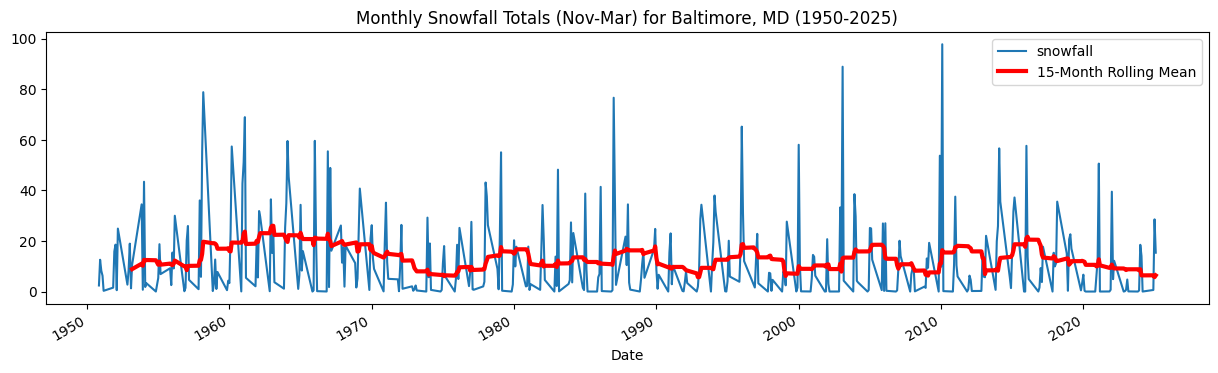

In [19]:
# Plot time series of raw monthly snowfall data
fig, ax = plt.subplots(figsize=(15,4))
snow_ds.plot(ax=ax)
ax.plot(snow_ds.rolling(window=15, center=False).mean(), label='15-Month Rolling Mean', c='red', linewidth=3)
ax.legend()
ax.set_title('Monthly Snowfall Totals (Nov-Mar) for Baltimore, MD (1950-2025)')

### Create standardized snowfall anomaly for each month

In [20]:
# Calculate monthly climatology (mean for each month) for 1981-2010
climatology_period = snow_ds['1981-01-01':'2010-12-31']

# Group by month and calculate mean and std for each month
monthly_mean = climatology_period.groupby(climatology_period.index.month).mean()
monthly_std = climatology_period.groupby(climatology_period.index.month).std()

# Calculate anomalies by subtracting the appropriate monthly mean
snow_anom = snow_ds.copy()
snow_anom['snowfall'] = snow_ds['snowfall'] - snow_ds.index.month.map(monthly_mean['snowfall'])

# Standardize anomalies using monthly std
snow_standard = snow_anom.copy()
snow_standard['snowfall'] = snow_anom['snowfall'] / snow_ds.index.month.map(monthly_std['snowfall'])

# Rename column 
snow_standard = snow_standard.rename(columns={'snowfall': 'snowfall_anom_standardized'})

snow_standard

,snowfall_anom_standardized
Date,
1950-11-01,0.128852
1950-12-01,0.138538
1951-01-01,-0.645800
1951-02-01,-0.640356
1951-03-01,-0.786346
...,...
2024-03-01,-0.815193
2024-11-01,-0.248017
2024-12-01,-0.775785


C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_18132\649401895.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(snow_standard.rolling(window=15, center=True).mean(), label='15-Month Rolling Mean', c='red', linewidth=3)


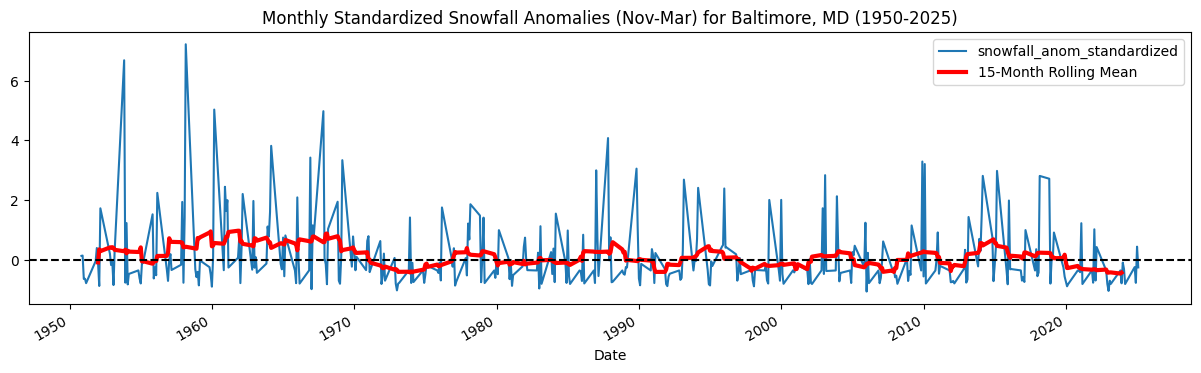

In [30]:
# Plot time series of raw monthly snowfall data
fig, ax = plt.subplots(figsize=(15,4))
snow_standard.plot(ax=ax)
ax.plot(snow_standard.rolling(window=15, center=True).mean(), label='15-Month Rolling Mean', c='red', linewidth=3)
ax.legend()
ax.set_title('Monthly Standardized Snowfall Anomalies (Nov-Mar) for Baltimore, MD (1950-2025)')
#ax.set_ylim(-2,15)
ax.axhline(0, color='black', linestyle='--')

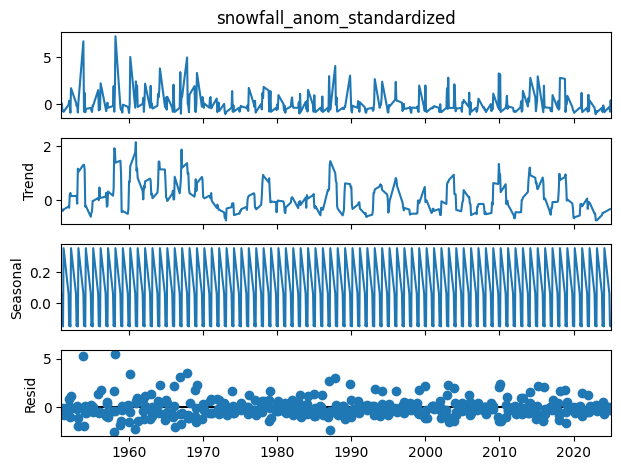

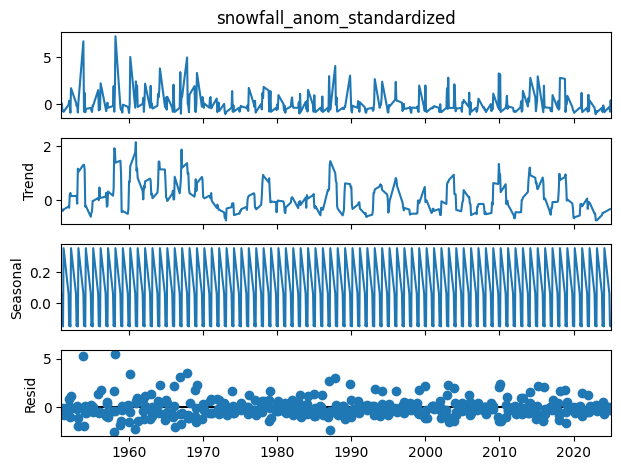

In [ ]:
# Time series decomposition plot
import statsmodels.api as sm
sm.tsa.seasonal_decompose(snow_standard['snowfall_anom_standardized'], model='additive', period=5).plot()

### After futher inspection of the time series with the standardized anomaly, it does not appear there is a significant long term trend in the monthly snowfall amounts in Baltimore. Decompostion reveals that there is seasonality but that is because we are initially looking at 5 months out of the year, and since our goal is to only focus in on which month(s) has the most predictability, we need not worry about this. Noise also remains fairly minimal outside of the first 10 years or so as well.

## Create lagged time series

In [26]:
# Shift teleconnection indices forward by 1 month
# This makes December indices align with January snowfall, for example.
newdf_all_lagged = newdf_all.shift(1)

# Merge lagged teleconnections with snowfall anomalies
df_lagged = newdf_all_lagged.merge(snow_standard, how='outer', on='Date')

# Drop rows with NaN (first row will have NaN teleconnections due to shift)
df_lagged = df_lagged.dropna()

# Rename snowfall column for clarity
df_lagged = df_lagged.rename(columns={'snowfall_detrended': 'snow_anom'})


df_lagged

,ENSO,PDO,NAO,AO,PNA,IOD,snowfall_anom_standardized
Date,,,,,,,
1950-11-01,-1.01,-1.92,0.85,-0.379,0.49,-0.35,0.128852
1950-12-01,-1.19,-1.45,-1.26,-0.515,-1.81,-0.20,0.138538
1951-01-01,-1.31,-1.06,-1.02,-1.928,0.02,-0.02,-0.645800
1951-02-01,-1.34,-1.19,0.08,-0.085,-0.41,-0.05,-0.640356
1951-03-01,-1.07,-1.52,0.70,-0.400,-1.36,0.28,-0.786346
...,...,...,...,...,...,...,...
2024-03-01,1.49,-1.33,1.09,0.635,0.09,0.28,-0.815193
2024-11-01,-0.25,-3.80,-0.38,0.525,0.04,-0.22,-0.248017
2024-12-01,-0.19,-3.13,-0.23,-0.037,0.06,-0.39,-0.775785


### So now in this dataframe, for a given row, the date corresponds to that month's snowfall anomaly, and the teleconnection indices correspond to the month prior (so a row with October snowfall anoms contains September's indices).

# Some EDA with Correlation and Pair plots

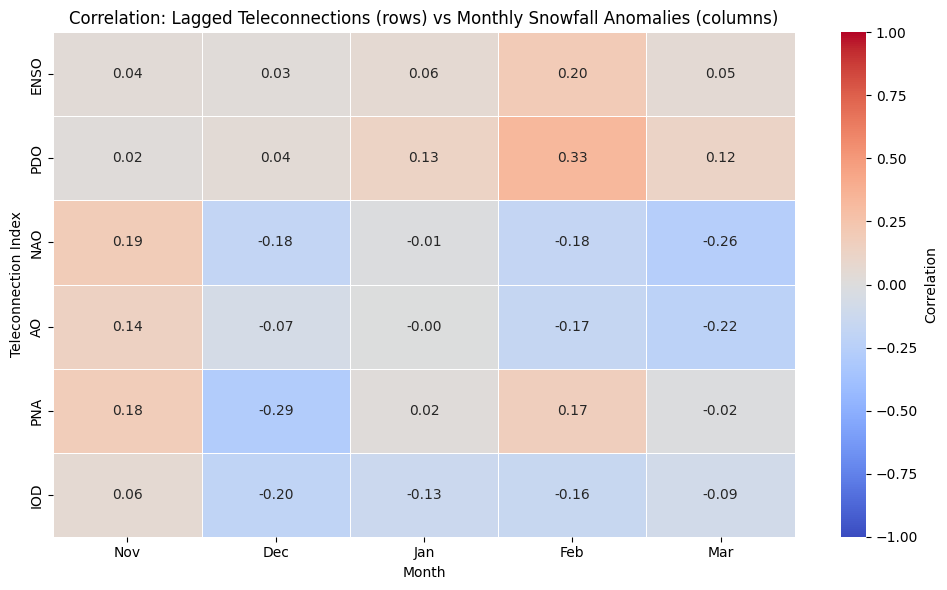

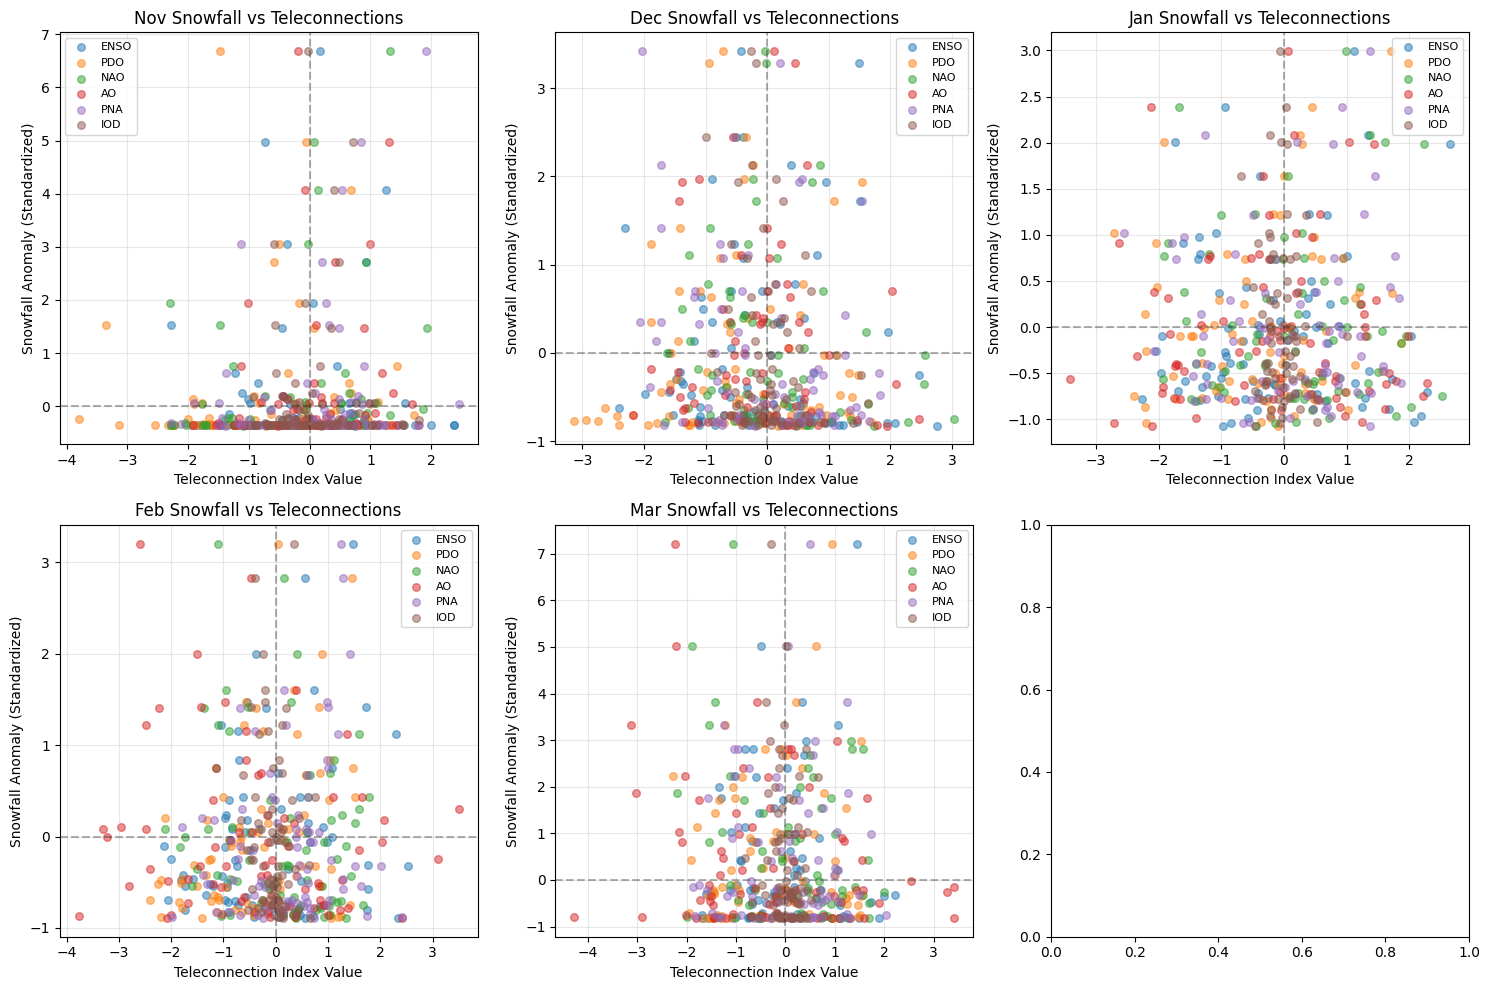

In [29]:
import seaborn as sns

# Add month column to the lagged dataframe
df_lagged['month'] = df_lagged.index.month

# Create month name mapping
month_names = {11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}

# Pivot data to create separate columns for each month's snowfall anomaly
df_pivot = df_lagged.copy()
df_pivot['month_name'] = df_pivot['month'].map(month_names)

# Create correlation matrix with teleconnections vs each month's snowfall
teleconnections = ['ENSO', 'PDO', 'NAO', 'AO', 'PNA', 'IOD']
months = [11, 12, 1, 2, 3]

# Calculate correlations between each teleconnection and each month's snowfall
corr_matrix = pd.DataFrame(index=teleconnections, columns=[month_names[m] for m in months])

for telecon in teleconnections:
    for month in months:
        month_data = df_lagged[df_lagged['month'] == month]
        if len(month_data) > 1:
            corr = month_data[telecon].corr(month_data['snowfall_anom_standardized'])
            corr_matrix.loc[telecon, month_names[month]] = corr
        else:
            corr_matrix.loc[telecon, month_names[month]] = np.nan

# Convert to numeric
corr_matrix = corr_matrix.astype(float)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, 
            fmt=".2f", linewidths=.5, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title("Correlation: Lagged Teleconnections (rows) vs Monthly Snowfall Anomalies (columns)")
plt.xlabel("Month")
plt.ylabel("Teleconnection Index")
plt.tight_layout()
plt.show()

# Create scatter plots for each month
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, month in enumerate(months):
    ax = axes[idx]
    month_data = df_lagged[df_lagged['month'] == month]
    
    # Plot each teleconnection vs snowfall for this month
    for telecon in teleconnections:
        ax.scatter(month_data[telecon], month_data['snowfall_anom_standardized'], 
                  alpha=0.5, s=30, label=telecon)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('Teleconnection Index Value')
    ax.set_ylabel('Snowfall Anomaly (Standardized)')
    ax.set_title(f'{month_names[month]} Snowfall vs Teleconnections')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### On the whole, February seemed to have the highest magnitude lagged correlations with the teleconnections, including the highest with PDO with a correlation of 0.33. For the purposes of this assignment, we will focus on February snow anomalies moving forward as it may provide our greatest degree of predictability.

In [33]:
# Select snow anoms only from February (January teleconnections)
feb_lagged = df_lagged[df_lagged.index.month.isin([2])].copy()
feb_lagged

,ENSO,PDO,NAO,AO,PNA,IOD,snowfall_anom_standardized,month
Date,,,,,,,,
1951-02-01,-1.34,-1.19,0.08,-0.085,-0.41,-0.05,-0.640356,2
1952-02-01,0.08,-2.19,0.93,0.368,-1.98,0.05,-0.880787,2
1953-02-01,0.14,-0.16,0.33,-1.036,0.65,0.40,-0.850075,2
1954-02-01,0.38,-1.13,0.37,-0.148,-1.14,-0.29,-0.827524,2
1955-02-01,-0.98,-0.23,-1.84,-1.163,0.40,-0.42,-0.116736,2
...,...,...,...,...,...,...,...,...
2021-02-01,-1.05,-0.61,-1.11,-2.484,0.19,0.12,1.222565,2
2022-02-01,-0.98,-2.40,1.08,0.848,1.01,-0.26,-0.697518,2
2023-02-01,-0.78,-1.24,1.25,-0.674,0.21,0.05,-0.703903,2


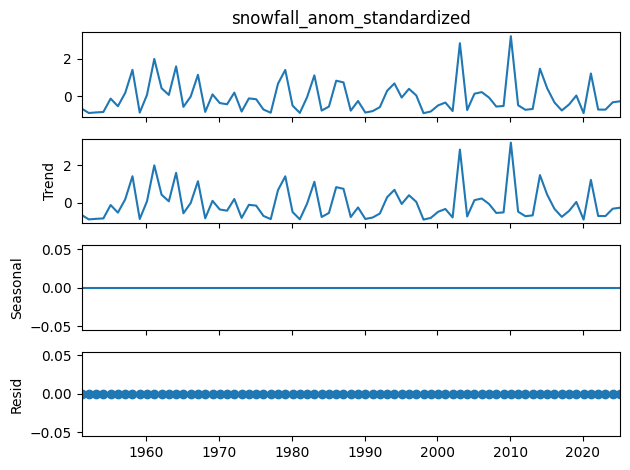

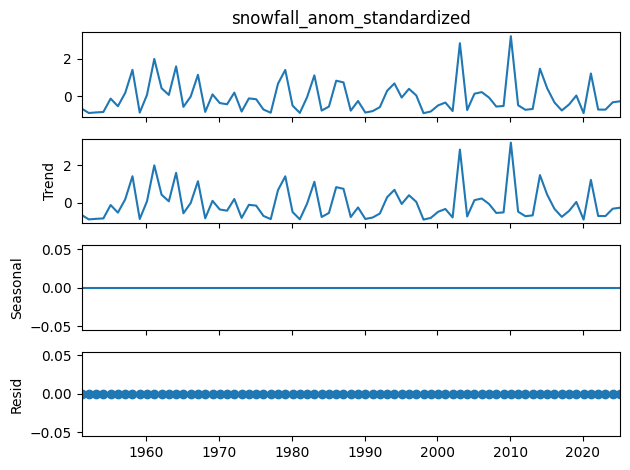

In [ ]:
# Time series decomposition plot
sm.tsa.seasonal_decompose(feb_lagged['snowfall_anom_standardized'], model='additive', period=1).plot()

# Test different models

Trying different non-linear, tree models. Tree models were selected since they can handle multi-collinearity better, which is important since our teleconnections may not always be absolutely independent of one another. I employ the Random Forest Regression, GB Regression, and XGB Regression.
The metrics will be compared once all are run to determine the best model.

In [37]:

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor

RANDOM_STATE = 42

# Split data into test and training
# X = features
# y = target
# Since we are working with chronological data,
# we split it up into the first ~55 years for training
# and the last 20 for testing
split_date = "2004-01-01"  # adjust if desired

train = feb_lagged[feb_lagged.index < split_date]
test = feb_lagged[feb_lagged.index >= split_date]

X_train = train[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_train = train['snowfall_anom_standardized']

X_test = test[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_test = test['snowfall_anom_standardized']

# Time-series CV 
# Since we only have 75 years of data, 
# we employ time-series cross-validation.
tscv = TimeSeriesSplit(n_splits=5)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Grid search params
rf_params = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [1, 3, 5, 10, 25, 50],
    "min_samples_leaf": [2, 3, 4]
}

gb_params = {
    "n_estimators": [300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

xgb_params = {
        "n_estimators": [400, 600],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
    }


# Compute RMSE from CV
from sklearn.model_selection import cross_val_score

def cv_rmse(model):
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=rmse_scorer)
    return -np.mean(scores)


######### Run Grid Searches ##########

results = {}

# RandomForest
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
results["RandomForest"] = {
    "best_params": rf_grid.best_params_,
    "best_r2": rf_grid.best_score_,
    "best_rmse": cv_rmse(rf_best),
    "model": rf_best
}

# GradientBoosting
gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb_grid = GridSearchCV(
    gb,
    gb_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)

gb_best = gb_grid.best_estimator_
results["GradientBoosting"] = {
    "best_params": gb_grid.best_params_,
    "best_r2": gb_grid.best_score_,
    "best_rmse": cv_rmse(gb_best),
    "model": gb_best
}

# XGBoost 
xgb = XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror')
xgb_grid = GridSearchCV(
    xgb,
    xgb_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_
results["XGBoost"] = {
    "best_params": xgb_grid.best_params_,
    "best_r2": xgb_grid.best_score_,
    "best_rmse": cv_rmse(xgb_best),
    "model": xgb_best
}

# Print results from grid search for each moodel
print("\nBEST MODELS (after GridSearchCV)")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Best R2:   {res['best_r2']:.3f}")
    print(f"  Best RMSE: {res['best_rmse']:.3f}")
    print(f"  Params:    {res['best_params']}")

# Pick best overall modeel
best_name = max(results, key=lambda k: results[k]["best_r2"])
best_model = results[best_name]["model"]

print(f"\nBEST OVERALL MODEL: {best_name}")

# Fit best model to training dataset
best_model.fit(X_train, y_train)



BEST MODELS (after GridSearchCV)

RandomForest:
  Best R2:   -0.068
  Best RMSE: 0.767
  Params:    {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 100}

GradientBoosting:
  Best R2:   -0.327
  Best RMSE: 0.859
  Params:    {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}

XGBoost:
  Best R2:   -0.162
  Best RMSE: 0.812
  Params:    {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}

BEST OVERALL MODEL: RandomForest


,n_estimators,100
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


RMSE: 0.9366408212511466
Correlation Coeff: 0.21129578677123576
R-squared: -0.007077796172769046


Text(0.5, 1.0, 'Actual vs. Predicted Monthly February Snowfall')

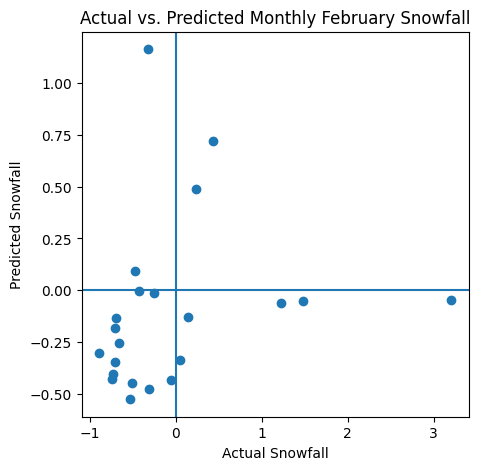

In [38]:
# Predict tornado count on test data
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE
corr = stats.pearsonr(y_test, y_pred) # Corr coeff
r2 = r2_score(y_test, y_pred) # Corr coeff

print(f'RMSE: {rmse}\nCorrelation Coeff: {corr.statistic}')
print(f'R-squared:', r2)
# Scatter plot of test vs. predicted data
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(y_test, y_pred)
ax.axvline(0)
ax.axhline(0)
ax.set_xlabel('Actual Snowfall')
ax.set_ylabel('Predicted Snowfall')
ax.set_title('Actual vs. Predicted Monthly February Snowfall')

In [13]:
# First look at accuracy score of model
print(f"RF train accuracy: {best_model.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {best_model.score(X_test, y_test):.3f}")

RF train accuracy: 0.633
RF test accuracy: -0.006


### It appears that this model does not have much skill when trying to predict the snowfall anomalies for the given month. However, if we take a look at the scatter plot, we see that the majority of points are less than zero for both predicted and actual values. Maybe rather than trying to predict the snowfall anomaly value, we could try having the model simply predict whether there will be above or below average snowfall for the given month. In other words, turn it into a binary classfier. Let's try that approach...

In [42]:
# Add column to denote rows where snowfall is above avg
feb_lagged["above_normal"] = (feb_lagged["snowfall_anom_standardized"] > 0).astype(int)
feb_lagged

,ENSO,PDO,NAO,AO,PNA,IOD,snowfall_anom_standardized,month,above_normal
Date,,,,,,,,,
1951-02-01,-1.34,-1.19,0.08,-0.085,-0.41,-0.05,-0.640356,2,0
1952-02-01,0.08,-2.19,0.93,0.368,-1.98,0.05,-0.880787,2,0
1953-02-01,0.14,-0.16,0.33,-1.036,0.65,0.40,-0.850075,2,0
1954-02-01,0.38,-1.13,0.37,-0.148,-1.14,-0.29,-0.827524,2,0
1955-02-01,-0.98,-0.23,-1.84,-1.163,0.40,-0.42,-0.116736,2,0
...,...,...,...,...,...,...,...,...,...
2021-02-01,-1.05,-0.61,-1.11,-2.484,0.19,0.12,1.222565,2,1
2022-02-01,-0.98,-2.40,1.08,0.848,1.01,-0.26,-0.697518,2,0
2023-02-01,-0.78,-1.24,1.25,-0.674,0.21,0.05,-0.703903,2,0


### Set up Random Forest Classifier. 
I use RF once again since that showed the best performance among the tree models.

In [66]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
                             accuracy_score, precision_score, recall_score)

# Train/test split
split_date = "2004-01-01"
train = feb_lagged[feb_lagged.index < split_date]
test = feb_lagged[feb_lagged.index >= split_date]

X_train = train[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_train = train['above_normal']

X_test = test[['ENSO','PDO','NAO','AO','PNA','IOD']]
y_test = test['above_normal']

# Time series CV
tscv = TimeSeriesSplit(n_splits=5)


# Comprehensive Model CV grid for Random Forest Classifier
model_grids = {
    "RF": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300, 500, 700],
            "max_depth": [ 5, 7, 10, 15, 20, None],
            "min_samples_split": [2, 4, 6, 8, 10, 15, 20],
            "min_samples_leaf": [1, 2, 3, 4, 5, 8, 10],
        }
    },
}


# Get best model
best_models = {}
for name, cfg in model_grids.items():
    print(f"\nTuning {name}")
    
    gs = GridSearchCV(
        estimator=cfg["model"],
        param_grid=cfg["params"],
        cv=tscv,
        scoring="balanced_accuracy",
        n_jobs=-1
    )
    
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    
    print("Best Params:", gs.best_params_)
    print("Best CV Balanced Accuracy:", gs.best_score_)


# Evaluate best model on test data
for name, model in best_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]

    print(f"\nDone {name}")




Tuning RF
Best Params: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 700}
Best CV Balanced Accuracy: 0.5866666666666667
Best Params: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 700}
Best CV Balanced Accuracy: 0.5866666666666667

Done RF

Done RF


# Model Performance using confusion matrix and ROC and PR curve

Optimal Threshold: 0.2889882181310753
Accuracy:  0.682
Precision: 0.500
Recall:    1.000


<Figure size 640x480 with 0 Axes>

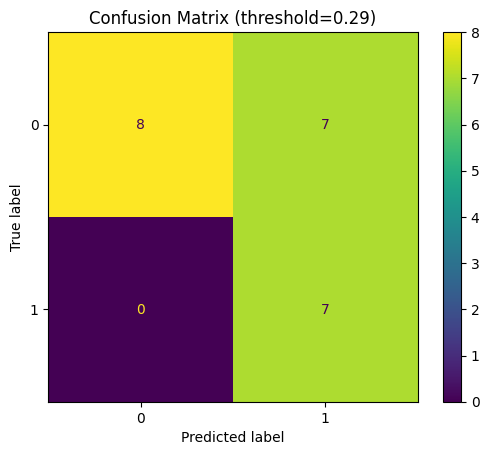

<Figure size 640x480 with 0 Axes>

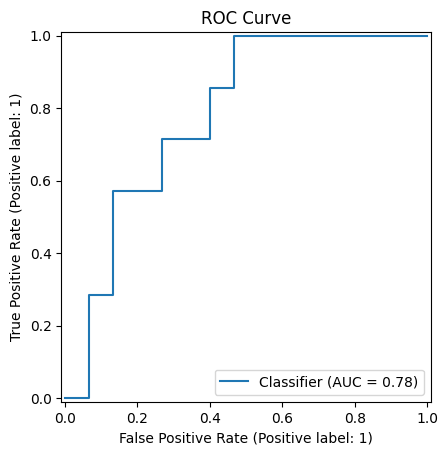

<Figure size 640x480 with 0 Axes>

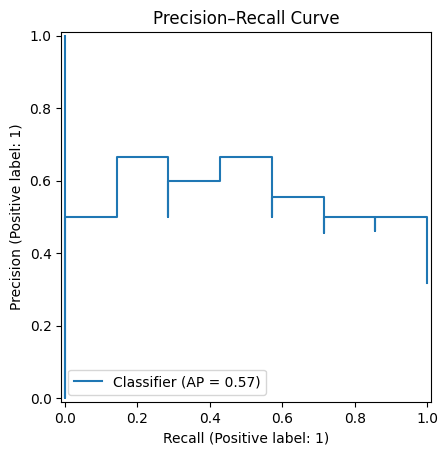

In [71]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_test, preds)

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Get optimal threshold for probs
j_scores = tpr - fpr
optimal_threshold = thresholds[j_scores.argmax()]

print("Optimal Threshold:", optimal_threshold)

# Performance evaluation
y_pred = (probs >= optimal_threshold).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

print(f"Accuracy:  {acc:.3f}\nPrecision: {prec:.3f}\nRecall:    {rec:.3f}")

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix (threshold={optimal_threshold:.2f})")
plt.show()


# ROC
fig = plt.figure()
RocCurveDisplay.from_predictions(y_test, probs)
plt.title("ROC Curve")
plt.show()

# PR
fig = plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.title("Precision–Recall Curve")
plt.show()


### This simplified classification method shows more promise in terms of predictability than the previous method. It is important to consider that it is a relatively small test sample size (21 years), but an accuracy score of of 0.68 and an ROC AUC of 0.78 demonstrates that this model does have some skill. It seems to over-predict above average snowfall (precision score of only 0.5 shows this), but given the complexity of the interactions between teleconnections and synoptic scale weather patterns that produce snowfall for this location, I would rate this as decent performance. Because this model shows some skill, we can also use it to look at feature importance to get a better idea of which teleconnections tend to impact February snowfall more. 

# Feature Importance

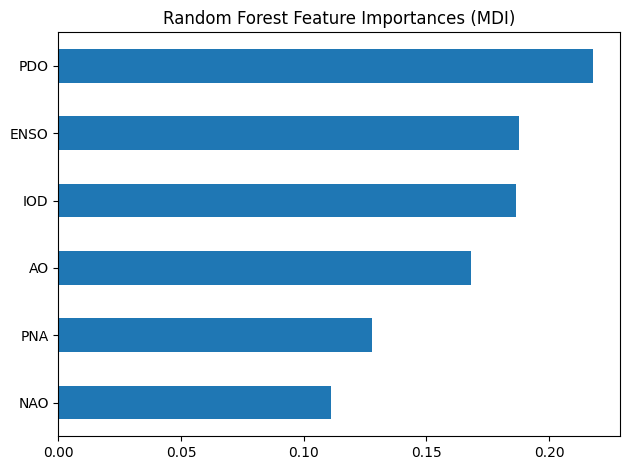

In [72]:
# Feature importance from Mean Decrease in Impurity (MDI)

# Grab feature names
feature_names = ['ENSO','PDO','NAO','AO','PNA','IOD']

# Create series of model feature importnances and sort
# from highest to lowest.
mdi_importances = pd.Series(
    model.feature_importances_, index=feature_names
).sort_values(ascending=True)

# Plot bar graph of MDI for each feature
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

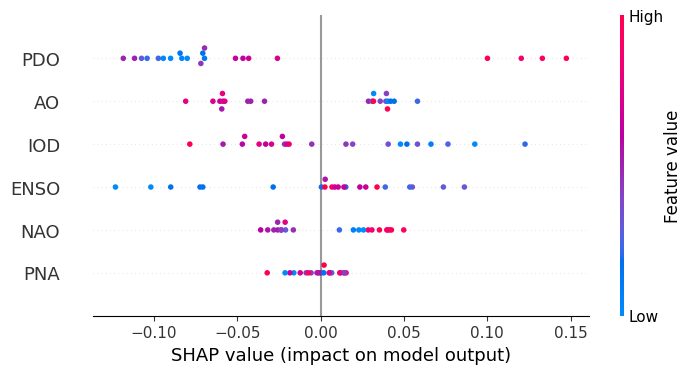

<Figure size 640x480 with 0 Axes>

In [73]:
# SHAP summary 
import shap

# SHAP explainer RF regression model
explainer = shap.TreeExplainer(model)
# Estimate SHAP values for test features based on rf model
shap_values = explainer(X_test)
# Select output = class 1
shap_values_class1 = shap_values[:, :, 1]

# Create summary plot (using beeswarm),
plt.figure(figsize=(12, 7))
shap.plots.beeswarm(shap_values_class1)
plt.tight_layout()

# Final Conclusions

When using the binary classifier method to predict whether the given month would have above or below average snowfall, we got a better idea of the relationships between monthly snowfall and teleconnections. I hesitate to say better performance overall since the previous method was predicting continuous values while this method was predicting binary values, which gives two different interpretations. However, seeing as we achieved ~68% accuracy on the test values and a 0.78 AUC in the ROC curve, I would say this isn't all that bad performance. 

Looking at feature importance, it's clear that the model tended to weigh the PDO the heaviest based on the MDI and SHAP importance ranking. Looking at the SHAP summary plot, it seems that a +PDO strongly influenced the model to predict above average snowfall, given the red data points on the right end of the SHAP value spectrum. Likewise, -PDO tended to favor below average snowfall. There is a discrepency between the MDI and SHAP rankings for the next couple indices, but since we care the most about whether positive or negative indices favor above or below average snowfall, let's focus on the SHAP plot. The second most important index was AO. Below average snowfall was almost always favored by +AO, while above average snowfall tended to be favored by negative AO, though there were some exceptions in the model. This is encouraging to see as physically speaking, a +AO generally doesn't favor cold enough air masses to make their way down to Baltimore to produce large snowfall events, while the opposite is true of a -AO. The index with the least influence and the most random predictability seemed to be the PNA, with both +/- PNA indices not favoring above or below average snowfall too strongly in either direction. 

It's important to keep in mind that this model and its results were only conducted for one city for one calendar month (February), and its possible that Baltimore just does not have very high predictability when it comes to monthly snowfall and lagged teleconnections. If I had more time and resources, I think a CONUS wide analysis would be worthwhile to see which regions have more predictability for monthly snowfall, and for which months as well. 